# BF vertex renormalization

Notebook for the analysis of BF vertex renormalization

## Setup

In [3]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [1]:
using Statistics
using StatsBase
using StatsPlots

In [2]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.3)

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the *layers averaging* over 20 trials and the error with the standard deviation. Then, we sum the average value of the layers and we sum variances

In [4]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [5]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

In [6]:
error_relative_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

In [7]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc10K = error_Nmc10K./amplitude_Nmc10K;

In [8]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

plot1 = Plot{Plots.GRBackend() n=3}


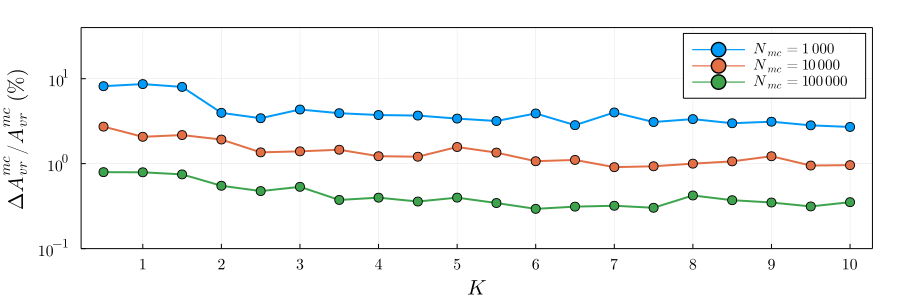

In [38]:
plot1 = plot(0.5:0.5:10,
               [100 .*error_relative_Nmc1K,100 .*error_relative_Nmc10K,100 .*error_relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylim = (0.1,40),
               yticks = [0.1, 1, 10],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc}  \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5
               )

savefig(plot1,"./plots/BF/vertex_renormalization/relative_errors.svg")
#savefig(plot1,"./plots/BF/vertex_renormalization/relative_errors.pdf")

@show plot1

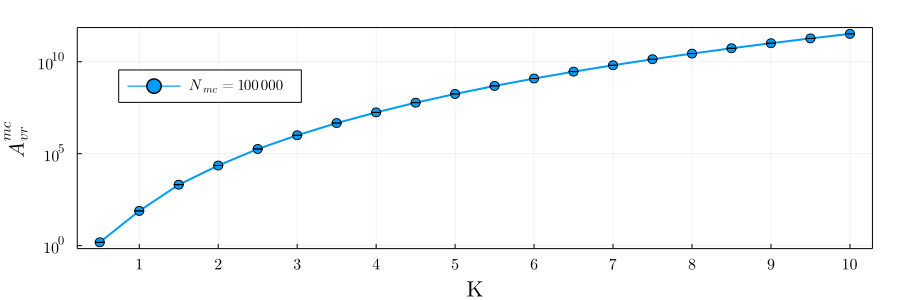

In [27]:
plot1 = plot(0.5:0.5:10,
               amplitude_Nmc100K,
               label = L"$N_{mc}=100\,000$",
               yscale=:log10,
               #xscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.141,0.735),
               size = (900, 300),
               ylabel = L"A_{vr}^{mc}",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1} +  c_4$$
and we perform the fit using only the last 10-ish points.

In [30]:
using LsqFit

In [31]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

3-element Vector{Float64}:
 11.202034596176222
  1.911943352301739
  1.7049503484391826

In [32]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
  0.6900349913108884
  4.3897270828935735
 10.824261362664098

## Changing face weights

We cannot discriminate between $c_1=10$, $11$ or $12$. To circumvent this problem we look at the amplitudes with modified face amplitude:

$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$

using as possible values of $\mu=0$, $\mu=0.1$, and $\mu=0.2$.

In [36]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_data_mu01(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.1/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu02 (generic function with 1 method)

In [39]:
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

In [40]:
layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);

In [41]:
layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);

The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

### Fit the amplitude with $\mu=0$

In [44]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

3-element Vector{Float64}:
  1.9553200307346141
  0.17602084512682833
 -0.05395489237380273

In [45]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.016748753556499588
 0.008837797654714614
 0.023172110440586847

### Fit the amplitude with $\mu=0.1$

In [46]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu01[10:end], c0)
fit.param

3-element Vector{Float64}:
 2.889229251406029
 0.1514730413431329
 0.07243257767389412

In [47]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.020020109408300128
 0.009501423853935199
 0.022265432328075145

### Fit the amplitude with $\mu=0.2$

In [48]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu02[10:end], c0)
fit.param

3-element Vector{Float64}:
 4.004971266726533
 0.08363926284157702
 0.2656980062235309

In [49]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 0.047028318066297245
 0.013763414764791567
 0.01854638320852474

It is reasonable that the exponent is not exactly compatible with $4$ for $\mu = 0.2$, since we are just using an approximation for the scaling.


The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

# Repeat the analysis for boundary intertwiner $i_b = 1$

As consistency check, we repeat the analysis for $i_b = 1$

In [50]:
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [51]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc10K = error_Nmc100K./amplitude_Nmc10K;

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

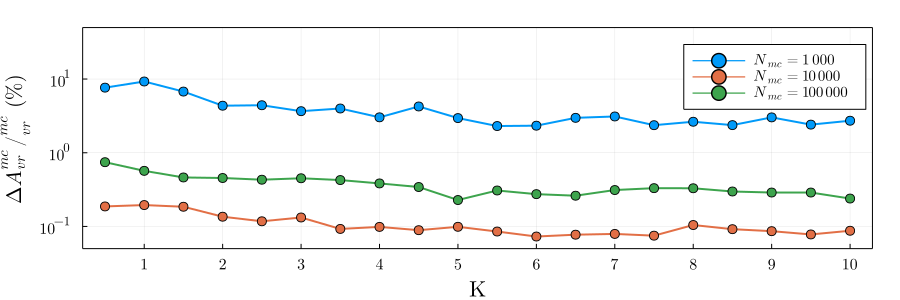

In [69]:
plot1 = plot(0.5:0.5:10,
               [100 .*abs.(error_relative_Nmc1K),100 .*abs.(error_relative_Nmc10K),100 .*abs.(error_relative_Nmc100K)],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.85),
               ylim = (0.05,50),
               size = (900, 300),
               ylabel = L"\Delta A^{mc}_{vr}/^{mc}_{vr} \ (\%)",
               xlabel = "K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

In [70]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], abs.(amplitude_Nmc100K[10:end]), c0)
fit.param

4-element Vector{Float64}:
  10.898198117641778
  20.744633294896506
 -38.12590016182282
   9.632684415675075e8

In [71]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
   0.6148075259881718
  39.005726020514544
 150.60025104582144
   1.2545522258970068e9

In [72]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


function get_data_mu01(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.1/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu0 = error_Nmc100K_mu0./amplitude_Nmc100K_mu0;

layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu01 = error_Nmc100K_mu01./amplitude_Nmc100K_mu01;

layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu02 = error_Nmc100K_mu02./amplitude_Nmc100K_mu02;

In [73]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.192381754742131
 -0.2985130632825387
 -1.1735412496337203
  2.65894871506023

In [74]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.2975114094636116
 0.3335292504886038
 0.5674412676015014
 1.2342510483529365

In [75]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu01[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.9685205033803856
 -0.4716374023532449
 -0.6500824016641867
  1.3593839417899631

In [76]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.06285172633639455
 0.10333548229402785
 0.273915920014054
 1.5384078908050305

In [77]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu02[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.124064419508863
 -0.2192143154991516
 -1.192666989304482
  0.4108781739337373

In [78]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.3942393921853753
 0.3308928113554509
 0.24358383284420138
 7.965391982588492